In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor




In [2]:
# Load the Walmart sales forecasting dataset:
train = pd.read_csv(r'C:\Users\Raghav\OneDrive\Desktop\stock\walmart-recruiting-store-sales-forecasting\train.csv.zip')
# - 'train.csv.zip' contains historical sales data for each store and department
features = pd.read_csv(r"C:\Users\Raghav\OneDrive\Desktop\stock\walmart-recruiting-store-sales-forecasting\features.csv.zip")
# - 'features.csv.zip' includes additional information like temperature, fuel price, promotions, etc.
stores = pd.read_csv(r'C:\Users\Raghav\OneDrive\Desktop\stock\walmart-recruiting-store-sales-forecasting\stores.csv')
# - 'stores.csv' provides store-level information such as store type and size
features.head()
# Display the first few rows of the features dataset to understand its structure

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [3]:
# Merge datasets to create a consolidated DataFrame:
df = train.merge(features, on=['Store', 'Date'])
df = df.merge(stores, on='Store')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  IsHoliday_y   421570 non-null  bool   
 15  Type          421570 non-null  object 
 16  Size          421570 non-null  int64  
dtypes: bool(2), float64(10), int64(3), object(2)
mem

In [5]:
# Convert the 'Date' column to datetime format for easier time-based analysis and feature extraction
df['Date'] = pd.to_datetime(df['Date'])


In [6]:
# Extract time-based features from the 'Date' column:
# - 'Year' for the calendar year
# - 'Month' for the calendar month
# - 'Week' for the ISO week number of the year
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week


In [7]:
# Fill missing values in the DataFrame with 0 to handle nulls and avoid errors during analysis/modeling

df.fillna(0, inplace=True)


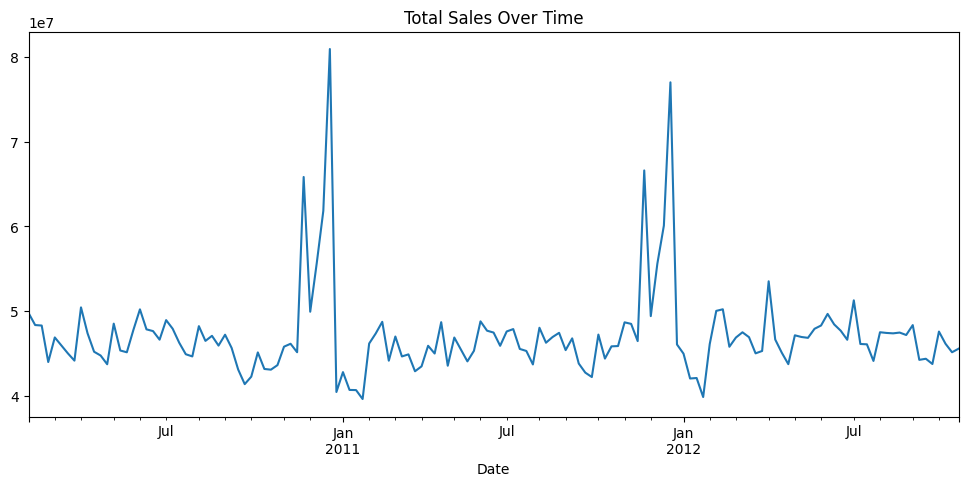

In [8]:
# Visualize total weekly sales over time:
# - Group data by 'Date' and sum 'Weekly_Sales' across all stores and departments
# - Plot the aggregated sales trend to observe patterns and seasonality

df.groupby('Date')['Weekly_Sales'].sum().plot(figsize=(12, 5))
plt.title("Total Sales Over Time")
plt.show()


<Axes: xlabel='Type', ylabel='Weekly_Sales'>

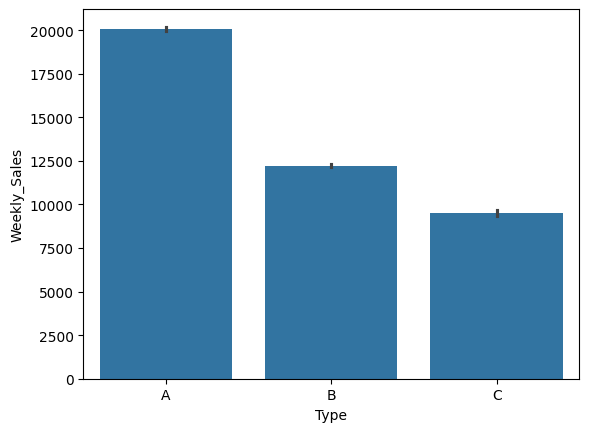

In [9]:
sns.barplot(x='Type', y='Weekly_Sales', data=df)


In [10]:
# The most common mistake associated with this dataset.

print(df.columns.tolist())  # Make sure 'IsHoliday' is there  
print(df[['Store', 'Date', 'IsHoliday']].head())  # Sample check


['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size', 'Year', 'Month', 'Week']


KeyError: "['IsHoliday'] not in index"

In [11]:
print(df[['IsHoliday_x', 'IsHoliday_y']].head())


   IsHoliday_x  IsHoliday_y
0        False        False
1         True         True
2        False        False
3        False        False
4        False        False


In [12]:
# Keep only one and rename it
df['IsHoliday'] = df['IsHoliday_y']
df.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1, inplace=True)


In [13]:
print(df[['Store', 'Date', 'IsHoliday']].head())


   Store       Date  IsHoliday
0      1 2010-02-05      False
1      1 2010-02-12       True
2      1 2010-02-19      False
3      1 2010-02-26      False
4      1 2010-03-05      False


<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

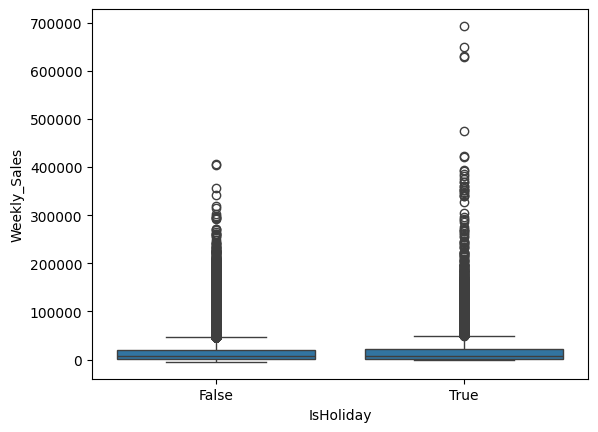

In [14]:
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=df)


In [15]:
# Create a lag feature 'Lag_1' representing the previous week's sales for each store and department:
# - Group by 'Store' and 'Dept', then use the shift function to get the previous week's sales

df['Lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)


In [16]:
# Convert object (string) columns to category codes
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category').cat.codes


In [17]:
# Prepare the dataset for modeling:
# - Drop 'Weekly_Sales' and 'Date' columns from the feature set 'X' as they are not used for prediction
# - 'y' is the target variable ('Weekly_Sales')
# - Split the data into training and testing sets, ensuring the time series data is not shuffled (shuffle=False)

X = df.drop(['Weekly_Sales', 'Date'], axis=1)
y = df['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)


In [18]:
model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
# Make predictions using the trained model:
# - Use the test set 'X_test' to generate predictions
# - Calculate and print the Root Mean Squared Error (RMSE) and R² score to evaluate model performance

preds = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("R2 Score:", r2_score(y_test, preds))


RMSE: 4008.68985333996
R2 Score: 0.9515829060095738


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

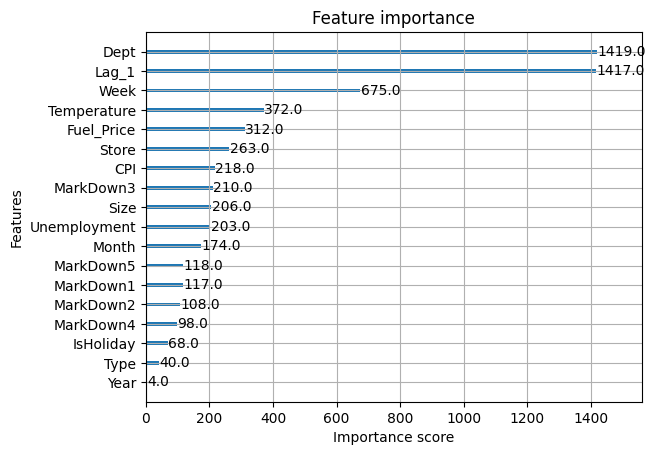

In [20]:
from xgboost import plot_importance
plot_importance(model)


In [22]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import time
import numpy as np

# Random Forest with limited trees
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

start_time = time.time()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
# Manually calculate RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
print("Random Forest RMSE:", rf_rmse)
print("RF Training Time: %.2f seconds" % (time.time() - start_time))


# XGBoost with fast training settings
xgb = XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.1, random_state=42, verbosity=0)

start_time = time.time()
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
# Manually calculate RMSE
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
print("XGBoost RMSE:", xgb_rmse)
print("XGB Training Time: %.2f seconds" % (time.time() - start_time))


Random Forest RMSE: 4711.845587056655
RF Training Time: 180.06 seconds
XGBoost RMSE: 4677.562631968994
XGB Training Time: 1.33 seconds
